<a href="https://colab.research.google.com/github/elsbethcodes/data-portfolio/blob/main/heart-disease/heart_disease_stats_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Health Factors Linked to Heart Disease

## Introduction
This notebook analyses patient information from the [Cleveland Clinic Foundation](https://doi.org/10.24432/C52P4X) related to heart disease using statistical tests including T-tests, ANOVA, Chi-Square and non-parametric tests.

The aim is to identify related health factors and study whether they are statistically associated with heart disease.

## Exploration of Dataset

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set notebook colour scheme
sns.set_palette("pastel") # default palette
hd_colour = '#E78C8C' # shade of red for presence of heart disease
no_hd_colour = '#7BAFD4' # shade of blue for absence of heart disease
hd_palette = {'presence': hd_colour, 'absence': no_hd_colour} # palette for heart disease groupings

from scipy.stats import ttest_ind # Two Sample T-Test (for independent groups)
from scipy.stats import mannwhitneyu # Mann Whitney U Test (for non-parametric groups)
from scipy.stats import f_oneway # ANOVA Test (analysis of variance)
from statsmodels.stats.multicomp import pairwise_tukeyhsd # Pairwise Tukey Test
from scipy.stats import chi2_contingency # Chi-Square Test

In [4]:
# load dataset
url = 'https://raw.githubusercontent.com/elsbethcodes/data-portfolio/refs/heads/main/heart-disease/heart_disease.csv'
heart = pd.read_csv(url)

In [5]:
# find information about column names, number of rows, null values, datatypes, etc.
print(heart.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            303 non-null    int64 
 1   sex            303 non-null    object
 2   trestbps       303 non-null    int64 
 3   chol           303 non-null    int64 
 4   cp             303 non-null    object
 5   exang          303 non-null    int64 
 6   fbs            303 non-null    int64 
 7   thalach        303 non-null    int64 
 8   heart_disease  303 non-null    object
dtypes: int64(6), object(3)
memory usage: 21.4+ KB
None


This dataset describes 303 patients with all information present for every patient.

The target variable in this analysis is heart_disease which is either 'presence' or 'absence' depending on whether the patient has heart disease or not.

In [6]:
# view the first 5 rows
print(heart.head())

   age     sex  trestbps  chol                cp  exang  fbs  thalach  \
0   63    male       145   233    typical angina      0    1      150   
1   67    male       160   286      asymptomatic      1    0      108   
2   67    male       120   229      asymptomatic      1    0      129   
3   37    male       130   250  non-anginal pain      0    0      187   
4   41  female       130   204   atypical angina      0    0      172   

  heart_disease  
0       absence  
1      presence  
2      presence  
3       absence  
4       absence  


We can see above the variables to be investigated in relation to heart_disease, which are as follows:

| Variable   | Description | Units |
|------------|-------------|-------|
| age        | Age | years |
| sex        | Sex assigned at birth (male or female) | - |
| trestbps   | Resting blood pressure | mm Hg |
| chol       | Serum cholesterol | mg/dl |
| cp         | Chest pain type | - |
| exang      | Exercise-induced angina (1 = yes, 0 = no)  | - |
| fbs        | Fasting blood sugar > 120 mg/dl (1 = yes, 0 = no)  | - |
| thalach    | Maximum heart rate achieved during exercise | bpm |

Below is a pairplot which shows a KDE plot of each quantitative variable on the diagonal and a scatter plot of each quantitative variable against the others on the non-diagonal.

A KDE plot is a histogram with smoothing so the height of the curve at a point x is proportional to the estimated probability density there.

Each graph is grouped by whether heart disease is present or not (red = presence, blue = absence).

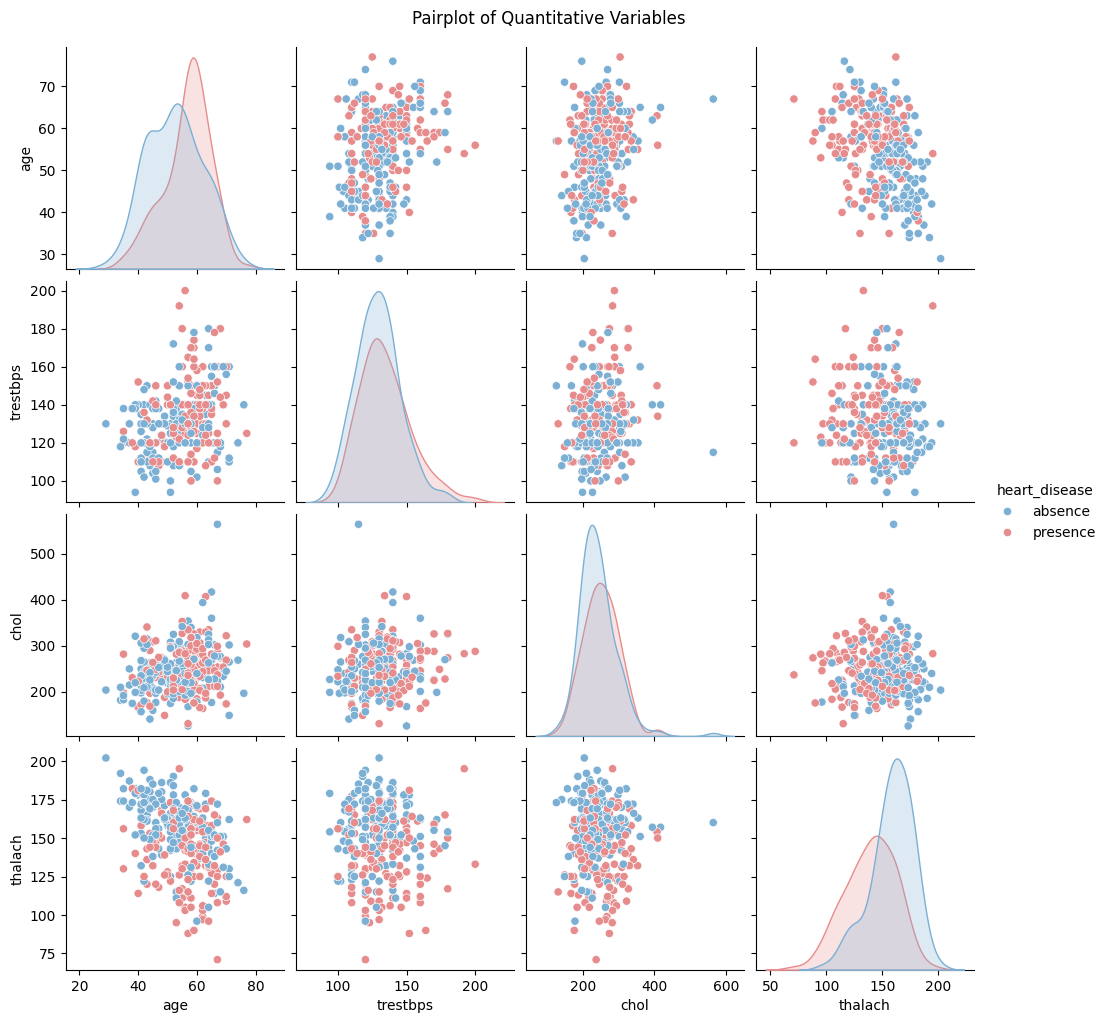

In [7]:
ax = sns.pairplot(vars=['age', 'trestbps', 'chol', 'thalach'], hue='heart_disease', palette=hd_palette, data=heart)
ax.fig.suptitle("Pairplot of Quantitative Variables",  y=1.02)
plt.show()

The scatterplots begin to show some trends, for example resting blood pressure (trestbps) is positively correlated with age whereas maximum heartrate achieved during exercise (thalach) is negatively correlated with age. We can also see clearly that maximum heartrate achieved during exercise (thalach) is lower in cases of heart disease (heart_disease).

Boxplots will help to show more insights that are obscured on the scatter plots.

## Maximum Heart Rate Achieved vs Presence of Heart Disease

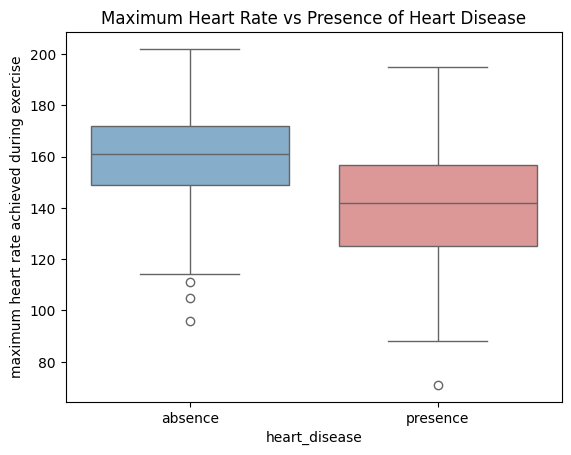

In [8]:
# boxplot for visual comparison of groups with heart disease vs without heart disease for the variable thalach
sns.boxplot(x='heart_disease', y='thalach', hue='heart_disease', palette=hd_palette, data=heart)
plt.ylabel('maximum heart rate achieved during exercise')
plt.title('Maximum Heart Rate vs Presence of Heart Disease')
plt.show()

The above boxplot shows that those with heart disease have a lower maximum heart rate achieved during exercise on average than those without heart disease.

In [9]:
# create groups
max_heart_rate_hd = heart['thalach'][heart['heart_disease']=='presence'] # group with heart disease
max_heart_rate_no_hd = heart['thalach'][heart['heart_disease']=='absence'] # group without heart disease

# check size of each group
print(f'Patients WITH heart disease in dataset: {len(max_heart_rate_hd)}')
print(f'Patients WITHOUT heart disease in dataset: {len(max_heart_rate_no_hd)}')

Patients WITH heart disease in dataset: 139
Patients WITHOUT heart disease in dataset: 164


In [10]:
# comparison of averages
mean_diff = np.mean(max_heart_rate_no_hd) - np.mean(max_heart_rate_hd)
median_diff = np.median(max_heart_rate_no_hd) - np.median(max_heart_rate_hd)

print(f'The group with heart disease differs in maximum heart rate to the group without heart disease by mean {round(mean_diff,1)} and median {round(median_diff,1)}.')

# comparison of variances
var_diff = np.var(max_heart_rate_hd) - np.var(max_heart_rate_no_hd)
print(f'The groups differ in variance by {round(var_diff,1)}.')

The group with heart disease differs in maximum heart rate to the group without heart disease by mean 19.1 and median 19.0.
The groups differ in variance by 140.4.


Does the group with heart disease differ significantly in maximum heart rate achieved during exercise to the group without heart disease at the 5% significance level?

Since we are comparing the averages of two independent groups to see if they are different, an independent two-tailed T-test is appropriate.


An independent T-test has 3 main conditions:
1.  Independence - ✅ implied by study design.
2.  Normality - ✅ the pairplot above shows that each group is roughly * normally distributed (see in more detail on the histograms below).
3.   Equal variances - ❎ there is a 140 difference so we will apply the version of a T-test that doesn't assume equal variances.

\* Each group has a sample size much larger than 30 so a T-test should be robust to minor violations of normality.

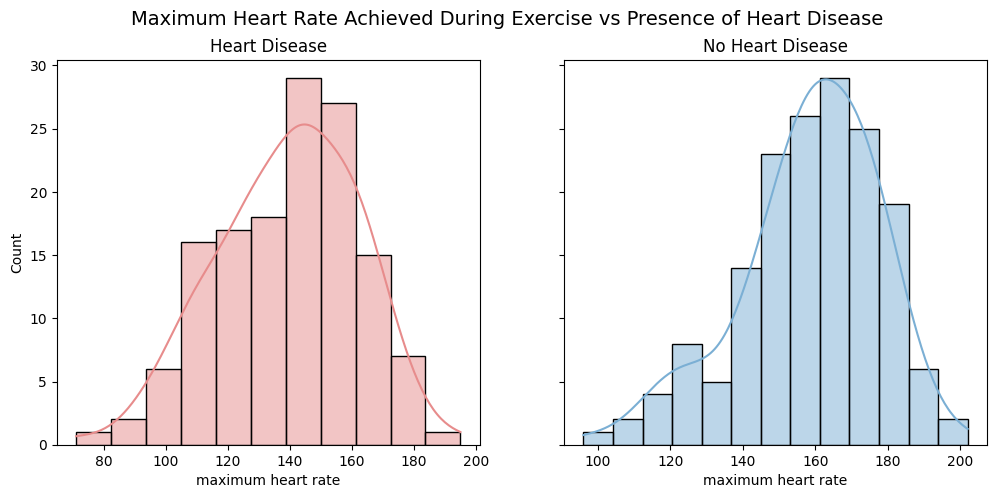

In [11]:
# Plot distributions of maximum heart achieved during exercise grouped by presence of heart disease

# Create figures of two side-by-side plots with a shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Subset data by heart_disease status
hd = heart[heart['heart_disease'] == 'presence']
no_hd = heart[heart['heart_disease'] == 'absence']

# Heart disease plot
sns.histplot(data=hd, x='thalach', ax=axes[0], kde=True, color=hd_colour)
axes[0].set_title('Heart Disease')
axes[0].set_xlabel('maximum heart rate')

# No heart disease plot
sns.histplot(data=no_hd, x='thalach', ax=axes[1], kde=True, color=no_hd_colour)
axes[1].set_title('No Heart Disease')
axes[1].set_xlabel('maximum heart rate')

fig.suptitle('Maximum Heart Rate Achieved During Exercise vs Presence of Heart Disease', fontsize=14)

plt.show()

In [12]:
# Independent two sample t-test (two-tailed)
# Null Hypothesis: The average maximum heart rate achieved during exercise for a patient with heart disease is equal to the average maximum heart rate achieved during exercise for a patient without heart disease.
# Alternative Hypothesis: The average maximum heart rate achieved during exercise for a patient with heart disease is NOT equal to the average maximum heart rate achieved during exercise for a patient without heart disease.

tval, pval = ttest_ind(max_heart_rate_hd, max_heart_rate_no_hd, equal_var=False)
print(f'T-test p-value: {pval}.')
if pval < 0.05:
  print('Conclusion: There is SIGNIFICANT evidence that the average maximum heart rate achieved during exercise for a patient with heart disease is NOT equal to the average maximum heart rate achieved during exercise for a patient with heart disease.')
  # Reject Null Hypothesis
else:
  print('Conclusion: There is INSIGNIFICANT evidence that the average maximum heart rate achieved during exercise for a patient with heart disease is NOT equal to the average maximum heart rate achieved during exercise for a patient with heart disease.')
  # Accept Null Hypothesis

T-test p-value: 9.106165923728815e-14.
Conclusion: There is SIGNIFICANT evidence that the average maximum heart rate achieved during exercise for a patient with heart disease is NOT equal to the average maximum heart rate achieved during exercise for a patient with heart disease.


We can do a similar investigation for age vs presence of heart disease.

## Age vs Presence of Heart Disease

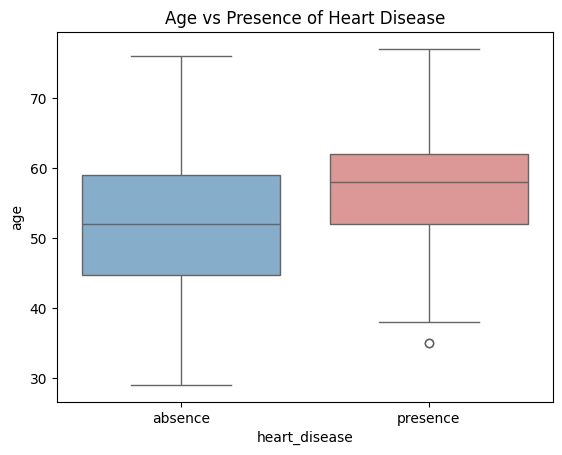

In [13]:
# boxplot for visual comparison
sns.boxplot(x='heart_disease', y='age', hue='heart_disease', palette=hd_palette, data=heart)
plt.title('Age vs Presence of Heart Disease')
plt.show()

The above boxplot shows that patients with heart disease have a higher median age than those who do not.

In [14]:
# create subgroups
age_hd = heart['age'][heart['heart_disease']=='presence']
age_no_hd = heart['age'][heart['heart_disease']=='absence']

In [15]:
# comparison of averages
mean_diff = np.mean(age_hd) - np.mean(age_no_hd)
median_diff = np.median(age_hd) - np.median(age_no_hd)
print(f'The group with heart disease differs in age to the group without heart disease by mean {round(mean_diff,1)} years and median {round(median_diff,1)} years.')

The group with heart disease differs in age to the group without heart disease by mean 4.0 years and median 6.0 years.


Is the difference in age between patients with heart disease and patients without heart disease significant at the 5% signficance level?

An independent two-tailed T-test seems appropriate again but we must first check the 3 main assumptions.
1.  Independence - ✅ implied by study design.
2.  Normality - ❌ the distribution of ages of patients with heart disease (see left histogram below) is a bimodal distribution so is not normally distributed.
3.   Equal variances - ❎ the boxplot implies unequal variances.

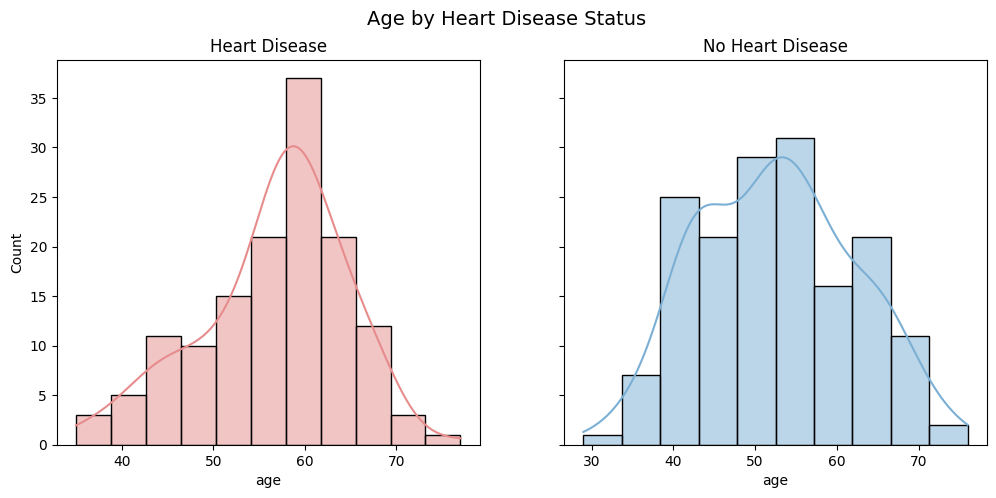

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create figures of two side-by-side plots with a shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Heart disease plot
sns.histplot(data=hd, x='age', ax=axes[0], kde=True, color=hd_colour)
axes[0].set_title('Heart Disease')

# No heart disease plot
sns.histplot(data=no_hd, x='age', ax=axes[1], kde=True, color=no_hd_colour)
axes[1].set_title('No Heart Disease')

fig.suptitle('Age by Heart Disease Status', fontsize=14)

plt.show()

Since the normality assumption has failed for the heart disease group, a non-parametric test like the Mann–Whitney U test is more suitable.

Note that this test has compares medians/distributions rather than means.

In [17]:
# Mann–Whitney U test:
# Null Hypothesis: The distribution of ages for a patient with heart disease is equal to the distribution of ages for a patient without heart disease.
# Alternative Hypothesis: The distribution of ages for a patient with heart disease is NOT equal to the distribution of ages for a patient without heart disease.
ustat, pval = mannwhitneyu(age_hd, age_no_hd, alternative='two-sided')
print(f'Mann–Whitney U test p-value: {pval}.')

if pval < 0.05:
  print('Conclusion: There is SIGNIFICANT evidence that the distribution of ages for a patient with heart disease is NOT equal to the distribution of ages for a patient without heart disease.')
  # Reject Null Hypothesis
else:
  print('Conclusion: There is NOT SIGNIFICANT evidence that the distribution of ages for a patient with heart disease is NOT equal to the distribution of ages for a patient without heart disease.')
  # Accept Null Hypothesis

Mann–Whitney U test p-value: 3.9172727066945255e-05.
Conclusion: There is SIGNIFICANT evidence that the distribution of ages for a patient with heart disease is NOT equal to the distribution of ages for a patient without heart disease.


So far we've used hypothesis tests on continuous quantitative variables.

We've learnt that the difference between patients with heart disease and without heart disease is statistically significant for the variables age and maximum heart rate achieved during exercise to a 5% significance level.

We can test for association of heart disease with categorical variables like chest pain using another type of hypothesis test: a Chi-Square test.

## Chest Pain Type vs Presence of Heart Disease

In [18]:
# create contingency table
Xtab = pd.crosstab(heart['cp'], heart['heart_disease'])
print(Xtab)

heart_disease     absence  presence
cp                                 
asymptomatic           39       105
atypical angina        41         9
non-anginal pain       68        18
typical angina         16         7


There are four different presentations of chest pain, with asymptomatic being the most common in this study.

Interestingly, typical angina (typical chest pain) is the least common for both patients with and without heart disease.

We can use the Chi-Square Test of Independence to test association of two categorical variables.

The assumptions are as follows:


1.   Categorical data - ✅ demonstrated by contingency table.
2.   Independence - ✅ no categories overlap.
3.   Minimum count of 5 in each cell of the contingency table - ✅ met (see above).


In [19]:
# Chi-square test of independence can compare two categorical variables, given a contingency table
# Null Hypothesis: there is no association between chest pain type and whether or not heart disease is present.
# Alternative Hypothesis: there is association between chest pain type and whether or not heart disease is present.
chi2, pval, dof, exp = chi2_contingency(Xtab)
print(f'Chi-square test p-value: {pval}.')
if pval < 0.05:
  print('Conclusion: There is SIGNIFICANT evidence that there is an association between chest pain type and whether or not heart disease is present in a patient.')
  # Reject Null hypothesis
else:
  print('Conclusion: There is NOT significant evidence that there is an association between chest pain type and whether or not heart disease is present in a patient.')
  # Accept Null hypothesis

Chi-square test p-value: 1.2517106007837527e-17.
Conclusion: There is SIGNIFICANT evidence that there is an association between chest pain type and whether or not heart disease is present in a patient.


Now we know that chest pain is associated with presence of heart disease, we may also be interested in whether maximum heart rate can predict which symptoms someone with heart disease is likely to experience.

This information could help raise awareness of symptoms.

We can begin by visualising different chest pain groups against maximum heart rate with a boxplot for patients with heart disease only.

## Maximum Heart Rate Achieved vs Chest Pain Type for Patients with Heart Disease

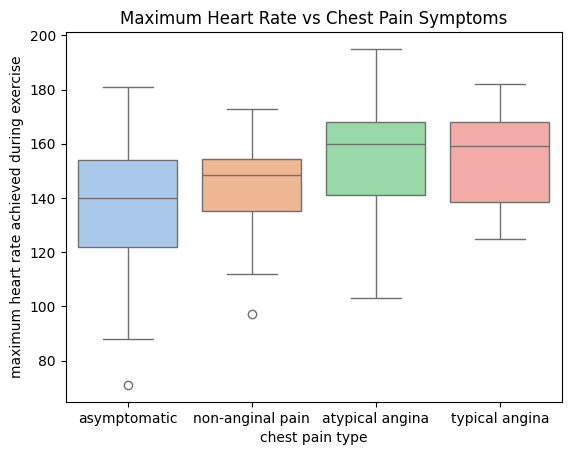

In [20]:
sns.boxplot(x='cp', y='thalach', hue='cp', palette='pastel', data=hd) # selected for heart disease only in data
plt.title('Maximum Heart Rate vs Chest Pain Symptoms')
plt.xlabel('chest pain type')
plt.ylabel('maximum heart rate achieved during exercise')
plt.show()

The above boxplot shows that patients with the asymptomatic case of heart disease tend to have a lower maximum heart rate on average.

Is this difference statistically significant?

An ANOVA test can be used to compare two or more means given the following conditions:


1.   Independence - ✅ implied by study design
2.   Normality - ✅ normality assumption for maximum heart rate during exercise confirmed true above.
3.   Homogenity of variance - ❎ boxplot suggests this does not hold so we will perform Welch's ANOVA test (for unequal variances).



In [21]:
# create subgroups by chest pain type
max_heart_typical = hd['thalach'][hd['cp']=='typical angina']
max_heart_asymptom = hd['thalach'][hd['cp']=='asymptomatic']
max_heart_nonangin = hd['thalach'][hd['cp']=='non-anginal pain']
max_heart_atypical = hd['thalach'][hd['cp']=='atypical angina']

In [22]:
# ANOVA test to compare two or more means (type 1 error limited to 5%)
# Null Hypothesis: Patients with typical angina, non-anginal pain, atypical angina, and asymptomatic patients all have the same average maximum heart rate.
# Alternative Hypothesis: Patients with typical angina, non-anginal pain, atypical angina, and asymptomatic patients do not all have the same average maximum heart rate.
fstat, pval = f_oneway(max_heart_typical, max_heart_asymptom, max_heart_nonangin, max_heart_atypical, equal_var=False)
print(f'ANOVA test p-value: {pval}')
if pval < 0.05:
  print('Conclusion: There is at least one pair of chest pain categories for which patients have statistically significant different maximum heart rates.')
  # Reject Null Hypothesis
else:
  print('Conclusion: No pair of chest pain categories has statistically significant different maximum heart rates.')
  # Accept Null Hypothesis

ANOVA test p-value: 0.0833315009162558
Conclusion: No pair of chest pain categories has statistically significant different maximum heart rates.


Although chest pain type is associated with heart disease, we have not discovered a significant link between chest pain type for heart disease patients and their maximum heart rate.

## Conclusion

* Statistical analysis of the Cleveland heart disease dataset revealed significant differences in age (age) and maximum heart rate achieved (thalach) between individuals with and without heart disease, as determined by T-tests.

* A Chi-Square test indicated a strong association between chest pain type (cp) and heart disease status.

* While visualisations suggested that asymptomatic cases of chest pain for heart disease patients might be linked to lower maximum heart rate achieved (thalach), an ANOVA test did not find this difference to be statistically significant at the 5% level.




## Evaluation

### Strengths

* A range of parametric and non-parametric methods were applied thoughtfully based on variable type and assumptions on distribution.

* Analytical decisions were transparent, and results were communicated with effective visualisations.

### Limitations

Data-related:

* The sample size (n = 303) is limited, which may affect the robustness and generalisability of findings.

* Some clinical variables, such as heart disease presence (heart_disease) and fasting blood sugar (fbs), were treated as binary, potentially oversimplifying complex conditions.

Methodological:

* Assumptions for parametric tests were checked visually but not formally tested. Incorporating formal tests (e.g. Shapiro-Wilk, Levene’s test) in future work would improve statistical rigor.

Future Directions:

* Further analysis could explore associations between heart disease and variables such as sex (sex), exercise-induced angina (exang), and fasting blood sugar (fbs) using Chi-Square tests.

* Right-skewed continuous variables like cholesterol (chol) and resting blood pressure (trestbps) could be log-transformed or analysed using non-parametric methods.

* A natural next step would be to build a predictive model — such as logistic regression — to assess the combined effect of multiple risk factors.

## Note
Thank you for reading my analysis, I hope it proved interesting. Please note that although this dataset contains real patient data, this project has been performed for learning purposes therefore conclusions should not be used to inform real health decisions.